<a href="https://colab.research.google.com/github/jhyoo78/jhyoo78/blob/main/NSP_Sentic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 참고 --> https://www.kaggle.com/code/ysthehurricane/next-word-prediction-bi-lstm-tutorial-easy-way

import os
import numpy as np
import pandas as pd

# 하나의 문장 내에서 다음 단어들을 맞출 때 import할 것들
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import load_model      # 저장한 모델 불러오기

# 단어가 아닌 sentence 단위로 전처리할 경우
import nltk
nltk.download('punkt')   # ‘punkt=문장 tokenizer’를 다운로드
from nltk.tokenize import word_tokenize, sent_tokenize
import re                # 파이썬 정규표현을 위한 표준 라이브러리임

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 시험용 Log 파일에 빈칸이 삽입되면 학습 과정에서 오류가 발생되니 주의할 것

In [ ]:
from google.colab import files     # Colab에서 local PC내의 file 읽어 들이는 라이브러리
uploaded = files.upload()          # 전처리한 정상상태 log == senticnet.xlsx 와 train.txt, test.txt (vnf3_0601_log.txt를 전처리 한 것) 파일을 선택하여 저장, 5~6분 소요

filenames = uploaded.keys()
print(filenames)


Saving train.txt to train.txt
dict_keys(['train.txt'])


## Senticnet.xlsx 전처리 하기:  
문장 예측 cell에서  단어 연산 결과를 polarity intensity로 변경하는 데 사용

In [ ]:
df = pd.read_excel('senticnet.xlsx', header= None, usecols=[0, 1])  # senticnet.xlsx 읽어 df로 변환, 0,8 번째 column만 읽음 --> 1 분 20초 소요
print('df = ', df)
#df.to_excel("senticnet_test.xlsx")   # 액셀 파일로 저장 --> 30 MB를 8MB로 줄였고 22초 소요
df.info()      # df 정보 확인
df.head()

df =                      0                   1
0             CONCEPT  POLARITY INTENSITY
1           abacinate              -0.863
2          abacterial              -0.843
3            abaction              -0.329
4             abactor              -0.329
...               ...                 ...
391556     zotob_worm              -0.834
391557  zotob_wrestle              -0.878
391558  zotob_wriggle              -0.928
391559   zotob_writhe              -0.942
391560             zz              -0.295

[391561 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391561 entries, 0 to 391560
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       391560 non-null  object
 1   1       391561 non-null  object
dtypes: object(2)
memory usage: 6.0+ MB


,0,1
0,CONCEPT,POLARITY INTENSITY
1,abacinate,-0.863
2,abacterial,-0.843
3,abaction,-0.329
4,abactor,-0.329


In [ ]:
# df의 특정 column을 key로 사용하여 value를 list로 출력하고자 할때, 여기서는 column = 0을 key로 사용함
val_dict= df.set_index(0).T.to_dict('list')   #  df를  {'fags': [-0.879],...} 형태로 변환, ==> 32 초 소요

# FastText embedding을 위한 전처리

In [ ]:
pre_processed_text = []

f = open('train.txt', 'r', encoding='UTF8')          # 1,100 줄의 log 파일
lines = f.readlines()

for line in lines:
    sent_text = sent_tokenize(line)     #  log msg를 줄 단위의 sentence로 토큰화
    #print(sent_text)

    # 각 문장에 대해서 구두점, LF 등을 제거하고, 대문자를 소문자로 변환.
    for string in sent_text:
        tokens = re.sub(r"[^a-z]+", " ", string.lower())   # 숫자 제거
        pre_processed_text.append(tokens)

f.close()

print("pre_processed_text=", pre_processed_text)
result=[pre_processed_text]
# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
#result = [word_tokenize(sentence) for sentence in pre_processed_text]

print('총 샘플의 개수 : {}'.format(len(result)))
print(result)
print(len(result[0]))

pre_processed_text= ['rsyslogd origin softwarersyslogd swversion xpid xinfohttpswwwrsyslogcom rsyslogd huped', 'systemd starting rotate log files', 'systemd starting daily mandb regeneration', 'systemd logrotateservice succeeded', 'systemd finished rotate log files', 'systemd mandbservice succeeded', 'systemd finished daily mandb regeneration', 'packagekit daemon start', 'dbus daemon system activating via systemd service nameorgfreedesktoppackagekit unitpackagekitservice requested uid pid commusrbingdbus call system dest orgfreedeskto labelunconfined', 'dbus daemon system successfully activated service orgfreedesktoppackagekit', 'systemd starting daily apt download activities', 'systemd starting packagekit daemon', 'systemd started packagekit daemon', 'systemd aptdailyservice succeeded', 'systemd finished daily apt download activities', 'packagekit daemon quit', 'systemd packagekitservice succeeded', 'server systemd resolved server returned error nxdomain mitigating potential dns viola

# FastText로 훈련하고 결과 저장

In [ ]:
# FastText로 훈련하고 결과 저장하기

from gensim.models import FastText
model = FastText(result, vector_size=200, window=5, min_count=1, workers=4, sg=1)

model.save('fasttext.h5')       # Keras는 모델의 구조와 가중치를 저장할 때 h5 파일형식을 권고
#model.wv.save_word2vec_format('fasttext_log') # Word2Vec 명령인데, fasttext 학습결과를 저장하면 다시 읽을 때 오류 발생(사용하지 말 것)

In [ ]:
# FastText 훈련 결과 확인
model.wv.most_similar('systemd started message of the day', topn=5)

[('systemd started message day', 0.999947726726532),
 ('systemd starting message day', 0.9991700649261475),
 ('systemd started haproxy load balancer', 0.9985579252243042),
 ('systemd started discard unused blocks week', 0.9984884858131409),
 ('systemd starting authorization manager', 0.9984852075576782)]

# 전처리 한 정상 상태 log를 토큰화함

In [ ]:
# log msg 를 sentence 단위로 토큰화 처리
input_sequences = []
log_sent = []

log_file_name='train.txt'

'''--------------------------------------------------------------'''

f=open(log_file_name, 'r')
lines = f.readlines()

for line in lines:
    sent_tok =  nltk.sent_tokenize(line)     #  log msg를 줄 단위로 sentence로 토큰화
    log_sent.append(sent_tok)

print("log_sents=", log_sent)
print("num_sent=", len(log_sent))

tokenizer = Tokenizer(oov_token='<oov>')     #  토큰화할 때 적용할 파라미터 --> 없는 단어를 '<oov>'로 처리함.
tokenizer.fit_on_texts(log_sent)             #  전체 문장의 index와 단어 벡터를 생성(Keras)
total_words = len(tokenizer.word_index) + 1  #  계산된 단어(문장)의 index를 dictionary 형태(word_index)로 변환

print("total unique sentences=", total_words)
print("tokeniizer.word_index=", tokenizer.word_index)

for msg in log_sent:
    #print(msg)                                    # log msg를 한 줄씩 출력
    token_list = tokenizer.texts_to_sequences([msg])[0]  # 각 문장(line)에 index를 부여해줌.
    #print("token_list=",token_list)                              # --> [
    input_sequences.append(token_list)
print("input_sequences=", input_sequences)       # ---> [[92], [93], [94], [95], [96], [97], [40],....] 등으로 출력됨
print("Total input sequences: ", len(input_sequences))    # ---> log file의 line 수
f.close()


log_sents= [['rsyslogd origin softwarersyslogd swversion xpid xinfohttpswwwrsyslogcom rsyslogd huped'], ['systemd starting rotate log files'], ['systemd starting daily mandb regeneration'], ['systemd logrotateservice succeeded'], ['systemd finished rotate log files'], ['systemd mandbservice succeeded'], ['systemd finished daily mandb regeneration'], ['packagekit daemon start'], ['dbus-daemon system activating via systemd service nameorgfreedesktoppackagekit unitpackagekitservice requested uid pid commusrbingdbus call system dest orgfreedeskto labelunconfined'], ['dbus-daemon system successfully activated service orgfreedesktoppackagekit'], ['systemd starting daily apt download activities'], ['systemd starting packagekit daemon'], ['systemd started packagekit daemon'], ['systemd aptdailyservice succeeded'], ['systemd finished daily apt download activities'], ['packagekit daemon quit'], ['systemd packagekitservice succeeded'], ['server systemd-resolved server returned error nxdomain miti

# 학습에 사용할 log 데이터의 차원 변경

In [ ]:
# Padding 대신에 학습에 사용할 log 데이터의 차원 변경을 위해 마지막 몇개 log msg를 버리고, 2차원(n x dim)으로 재구성하기

dim=4   #  4 이면 accuracy가 0.89, loss=  0.28 수준, dataset이 크고 다양해 지면 이보다 나빠짐.

#a = len(input_sequences)//dim  # 1101 // dim =>  몫 = 550
#b = len(input_sequences) % dim                 # 나머지 = 1
#print(a,"+", b)

new_input = []

input_seq = np.concatenate(input_sequences).tolist()  # 2차원 list를 1차원으로 축소.
print(len(input_seq))
print("input_seq=",len(input_seq), "개 -->", input_seq)

for i in range(len(input_sequences)-(dim-1)):   # dim에 맞추어 행렬의 column 수를 결정, input_sequences가 모두 포함되고 나머지가 없어야 함.
    new_input.append(input_seq[i: i+dim])

np_new_input = np.array(new_input)

print("np_new_input=", np_new_input[-4:-1])      # ===> 훈련 파일에 빈칸이 삽임되면 [[ 3  3  3  3] [ 3  3  3 81] [ 3  3 81 82]]에 list 라는 문자가 추가되는 문제(?) 발생함
print(len(np_new_input))

12528
input_seq= 12528 개 --> [966, 78, 114, 115, 79, 116, 117, 100, 169, 170, 29, 101, 111, 42, 31, 112, 171, 90, 43, 44, 95, 96, 24, 41, 25, 46, 47, 48, 49, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 59, 60, 86, 329, 330, 30, 37, 45, 102, 91, 118, 119, 120, 87, 121, 92, 122, 123, 63, 97, 29, 42, 31, 59, 60, 30, 37, 45, 102, 91, 95, 96, 24, 41, 25, 991, 43, 44, 63, 43, 44, 46, 47, 48, 49, 17, 18, 19, 20, 23, 26, 17, 18, 23, 17, 18, 19, 32, 26, 32, 19, 20, 28, 28, 20, 23, 26, 17, 18, 23, 19, 32, 26, 32, 20, 28, 28, 17, 18, 19, 20, 23, 26, 17, 18, 23, 19, 26, 20, 29, 42, 31, 56, 56, 56, 966, 78, 114, 115, 79, 116, 117, 95, 96, 24, 41, 25, 100, 169, 170, 29, 101, 111, 42, 31, 112, 171, 100, 169, 170, 87, 101, 111, 121, 92, 112, 171, 118, 119, 120, 122, 123, 17, 18, 23, 17, 18, 23, 19, 32, 26, 32, 19, 26, 20, 28, 28, 20, 17, 18, 19, 20, 17, 18, 23, 19, 32, 26, 32, 20, 28, 28, 17, 18, 23, 19, 26, 20, 18

# Xs, Ys 생성

In [ ]:
# create features and label
xs, labels = np_new_input[:, :-1], np_new_input[:,-1]   #   [:, :] 는 [all rows, all columns]을 지칭,  [:, :-1]은 all rows 와 마지막 column을 제외한 all columns, [:, -1] 은 last column의 모든 rows를 지칭
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)  # labels 내의 index 값으로 (전체 문장 개수에 대한) One-hot encoding을 해줌.

print("xs, shape=", xs.shape)
print("labels=", labels[:30])
print("ys_one-hot = ", ys)
print("labels_shape=",labels.shape)
print("ys_shape=", ys.shape)



xs, shape= (12525, 3)
labels= [ 115   79  116  117  100  169  170   29  101  111   42   31  112  171
   90   43   44   95   96   24   41   25   46   47   48   49 1132 1133
 1134 1135]
ys_one-hot =  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
labels_shape= (12525,)
ys_shape= (12525, 1501)


In [ ]:
# FastText embedding model 불러오기

loaded_model = FastText.load("fasttext.h5")
print(loaded_model.wv)                                        # 구조 정보만 출력됨
#loaded_model = FastText.load_fasttext_format('fasttext_log')   # 학습 후 저장한 것을 불러 올때 ....시도해 볼것...
loaded_model.wv.most_similar('systemd started message of the day', topn=5)     # loaded_model.most_similar()는 deprecated 되었음

FastTextKeyedVectors<vector_size=200, 1481 keys>


[('systemd started message day', 0.999947726726532),
 ('systemd starting message day', 0.9991700649261475),
 ('systemd started haproxy load balancer', 0.9985579252243042),
 ('systemd started discard unused blocks week', 0.9984884858131409),
 ('systemd starting authorization manager', 0.9984852075576782)]

In [ ]:
#  https://wikidocs.net/33793 참고해 만들었으나 23년 3월에 deprecated 되어서 loaded_model을 loaded_model.wv로 수정함
#  수정사항 참고-->  https://radimrehurek.com/gensim/models/fasttext.html에서 model.wv 참조,  word2vec 모델은 iterable 이지만 FastText는 아님.

print('모델의 크기(shape) :',loaded_model) # FastText 모델의 크기 확인

vocab_size= len(tokenizer.word_index.items()) +1   # 아래 cell에서 확인할 것
print(vocab_size)

def get_vector(str):
    if str in loaded_model.wv:               #### loaded_model(non-iterable)을 loaded_model.wv(iterable)로 수정함 ########
        return loaded_model.wv[str]
    else:
        return None;

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 200))

for word, index in tokenizer.word_index.items():
    # 단어와 매핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value


print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))

모델의 크기(shape) : FastText<vocab=1481, vector_size=200, alpha=0.025>
1501
임베딩 행렬의 크기(shape) : (1501, 200)


In [ ]:
print(tokenizer.word_index.items())  #각 sentence 와 매핑된 index 값을 확인해보자.

dict_items([('<oov>', 1), ('kernel acpiphp slot registered', 2), ('systemd starting snap daemon', 3), ('systemd stopped snap daemon', 4), ('systemd snapd service scheduled restart job restart counter', 5), ('snapd apparmor status apparmor enabled features available', 6), ('systemd snapd service start operation timed terminating', 7), ('systemd snapd service failed result timeout', 8), ('systemd failed start snap daemon', 9), ('server ovs-vswitchd ovssocketutilerreno valid ip address', 10), ('systemd-timesyncd timed waiting reply      ntp ubuntu com', 11), ('cloud-init ciinfo', 12), ('systemd-timesyncd network configuration changed trying establish connection', 13), ('kernel pm registered nosave memory mem', 14), ('kernel platform eisa allocate resource eisa slot', 15), ('kernel disabled', 16), ('sshd accepted password ubuntu port ssh', 17), ('sshd pamunixsshdsession session opened user ubuntu uid', 18), ('systemd-logind new session user ubuntu', 19), ('systemd started session user ubun

In [ ]:
print(loaded_model.wv['nit ciinfo'])   # log 파일에 없는 깨진 msg에도 정상 동작함

# 모델 학습

In [ ]:
# Bi- LSTM Neural Network Model training --> GPU 2분, CPU--> 22분 소요

model = Sequential()
#model.add(Embedding(total_words, 100, input_length = dim-1))
model.add(Embedding(total_words, 200, weights=[embedding_matrix], input_length = dim-1))   ########### FastText embedding으로 수정함.  202301230 00:08, trainable 사용 불가함.
model.add(Bidirectional(LSTM(64, return_sequences =True)))  # 추가

model.add(Bidirectional(LSTM(256)))                     # hidden units의 개수를 늘리기보다, 더 많은 hidden layer을 쌓는게 효과적, 수정 필요함.
#model.add(Dropout(0.1))                                # 과적합 방지 0.2 --> 별 효과 없음
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=30, verbose=1)  # epoch=50,   xs와 ys에 대해 학습을 시작함. 20--> 30으로 증대
#print model.summary()
print(model)

Epoch 1/30
392/392 [==============================] - 19s 19ms/step - loss: 4.7322 - accuracy: 0.2059
Epoch 2/30
392/392 [==============================] - 5s 13ms/step - loss: 1.8016 - accuracy: 0.6368
Epoch 3/30
392/392 [==============================] - 4s 10ms/step - loss: 1.1055 - accuracy: 0.7587
Epoch 4/30
392/392 [==============================] - 4s 9ms/step - loss: 0.8850 - accuracy: 0.7848
Epoch 5/30
392/392 [==============================] - 4s 11ms/step - loss: 0.7636 - accuracy: 0.8136
Epoch 6/30
392/392 [==============================] - 4s 10ms/step - loss: 0.6634 - accuracy: 0.8312
Epoch 7/30
392/392 [==============================] - 4s 10ms/step - loss: 0.6052 - accuracy: 0.8434
Epoch 8/30
392/392 [==============================] - 5s 12ms/step - loss: 0.5957 - accuracy: 0.8434
Epoch 9/30
392/392 [==============================] - 3s 9ms/step - loss: 0.5580 - accuracy: 0.8527
Epoch 10/30
392/392 [==============================] - 4s 9ms/step - loss: 0.5249 - accuracy

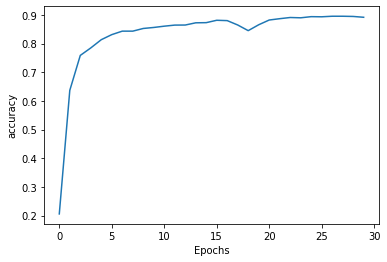

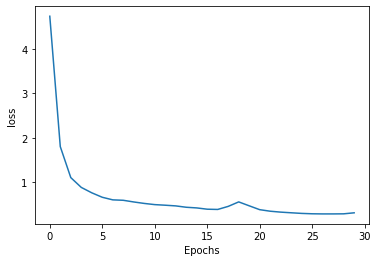

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Model 동작 여부 시험하기 (1)

연속된 3개의 문장으로 한 개의 다음 문장 예측하기

In [ ]:
# 연속된 2개의 문장으로 한 개의 다음 문장 예측하기

seed_text = 'systemd-logind new session user ubuntu', 'systemd-logind session logged waiting processes exit', 'systemd started session user ubuntu'

''' --------------------  실제 log msg를 파일에서 읽어 처리할 때  ------------------------'''
# model.pridict에 입력할 token_list 만들기
seed_tok=[]
for i in range(dim-1):
    sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg(seed_text)를 sentence 단위의 2차원 리스트로 만듬
    seed_tok.append(sd)
print("seed_tok=", seed_tok)

token = tokenizer.texts_to_sequences(seed_tok)    # log msg 토큰을 index 번호로 변환
print("token_list=", token)                       # 입력 문장의 index 값

token_list=[]
for a in token:
    token_list.append(a[0])                  # index의 숫자만 추출
token_list=[token_list]
print("token_list=", token_list)             # token_list = [[1, 2]] 와 같은 2차원 배열로 표시되어야 함
'''-------------------------------------------------------------------------------------------'''

y_prob = model.predict(token_list, verbose=0)    # model.predicted()로 입력 token_list에 대한 예측 결과를 출력.  model.predicted_classes()는 deprecated.
print(y_prob[0][:20], len(y_prob[0]))            # total_words(1500개 unique 문장) 각각에 대한 확률 20개를 출력하라--> [[1.3384e-06 1.2275e-06 5.1810e-04 ... 3.392e-05]]


predicted = y_prob[0].argmax(axis=-1)            # 가장 큰 확률 값을 갖는 단어의 index를 선택
                                                 # axis가 0 이면 2차원 행렬에서 열(가장 높은 차원), axis=1이면 행(다음으로 높은 차원), axis=-1이면 마지막 차원(가장 낮은 차원, 2차원에서는 행)을 기준 축으로 함
                                                 # argmax()는 가장 큰 값이 아닌 그 값의 인덱스 값을 반환함.
print("predicted index=", predicted)
prob= np.max(y_prob, axis=1)

#pred_rank = sorted(y_prob[0], reverse = True)   #  값이 큰 것부터 정렬(reverse=True), sort()는 원본 자료를 수정하고, sorted()는 원본은 그대로 두고 수정한 것을 리턴함.
#print(pred_rank[0][:5])
#print(pred_rank)

output_word = ""
for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
    if index == predicted:
        output_word = word
        break
seed_text = output_word
print(seed_text, prob)


seed_tok= [['systemd-logind new session user ubuntu'], ['systemd-logind session logged waiting processes exit'], ['systemd started session user ubuntu']]
token_list= [[19], [26], [20]]
token_list= [[19, 26, 20]]
[6.0929097e-09 5.6779923e-09 1.8644685e-07 2.5721924e-06 9.2801912e-07
 1.3626137e-06 1.4696480e-05 9.9337576e-06 1.4315992e-05 1.2400498e-05
 1.0226773e-04 1.8387427e-05 2.9005352e-07 2.4502208e-03 4.3565517e-08
 8.9088388e-07 1.3380020e-07 1.9338621e-02 1.7343906e-05 1.1208170e-02] 1500
predicted index= 28
systemd sessionscope succeeded [0.3225685]


# Model 동작 여부 시험하기 (2)
연속된 3개의 문장으로 다수의 Next Sentence를 예측하기

In [ ]:
seed_text = 'systemd-logind new session user ubuntu', 'systemd-logind session logged waiting processes exit', 'systemd started session user ubuntu'

num_to_predict = 3    # 예측할  다음 문장의 개수, 임의의 수로 변경 가능함.

''' --------------------  실제 log msg를 파일에서 읽어 처리할 때  ------------------------'''
# model.pridict에 입력할 token_list 만들기
seed_tok=[]
for i in range(dim-1):
    sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg를 sentence 단위로 토큰화
    seed_tok.append(sd)
print("seed_tok=", seed_tok)

token = tokenizer.texts_to_sequences(seed_tok)
print("token_list=", token)                 # 입력 문장의 index 값

token_list=[]
for a in token:
    token_list.append(a[0])
token_list=[token_list]
print("token_list=", token_list)            # token_list = [[1, 2]] 와 같은 2차원 배열로 표시되어야 함
'''-------------------------------------------------------------------------------------------'''
print("")

y_prob = model.predict(token_list, verbose=0)    # model.predicted()로 입력 token_list에 대한 예측 결과를 출력. model.predicted_classes 는 deprecated
#print(y_prob)

for i in range(num_to_predict):
    predicted = y_prob[0].argmax(axis=-1)
    print("predicted index =", predicted)

    prob= np.max(y_prob, axis=1)         # 2차원 array인 경우에 axis 사용함, 하나의 row에서 최대인 값
    np.put(y_prob[0], predicted, 0)         # np.array는 요소를 delete를 하면 새 array를 return하고 원본에서는 삭제가 안된다. 단, np.put(array, index, value) 등으로 변경은 가능하다.
    #np.delete(y_prob, predicted)

    output_word = ""
    for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
        if index == predicted:
            output_word = word
            break
    print("[", i+1,"번 ]", output_word, prob)


seed_tok= [['systemd-logind new session user ubuntu'], ['systemd-logind session logged waiting processes exit'], ['systemd started session user ubuntu']]
token_list= [[19], [26], [20]]
token_list= [[19, 26, 20]]

predicted index = 28
[ 1 번 ] systemd sessionscope succeeded [0.3225685]
predicted index = 188
[ 2 번 ] sshd received disconnect port disconnected user [0.25273207]
predicted index = 29
[ 3 번 ] systemd starting daily apt download activities [0.18640502]


# /var/log 파일에서 실시간으로 로그를 읽고 예측 및 감성(polarity)분석하기

In [ ]:
import os
import time   # sleep()
import datetime
from datetime import timedelta

####--------------- log 파일의 lines 수 세기 ----------------###

rpt = 0          # while loop 반복 횟수 초기화
list_ptr = [0]   # pointer(f.tell())의 위치 저장
list_line = [0]  # 파일의 line 번호

'''==============  비정상 log 파일 이름을 입력 ================      '''
while True:
    with open("test.txt", 'r') as f1:              # 처리할 log 파일 이름을 입력
        for count, line in enumerate(f1):          # enumerate()는 최소한의 메모리로 iterable 개체(string)를 count 하는데 사용됨, count에는 최종 라인의 번호가 저장됨.
            pass
    print('Total Lines', count + 1 )               # 파일의 line 수 세기

    '''---Daylight Saving Time (DST) 3월 중순~11월 첫 주에 변경 필요 ------'''
    current = datetime.datetime.now() + timedelta(hours = 9)        # 한국 시간( +9)으로 변환... timedelta는 days, hours 등을 연산하는 데 사용됨
    begin = current.replace(hour = 0, minute = 0, second = 7)       # sleep(5) 사용 시의 설정임(변경 필요)
    #print("current=", current, "begin=", begin)

    # 0시 0분 0초에 list를 초기화함.  sleep(5)를 사용하는 경우에는... 0시0분 0초 ~ 7초 사이에 이 코드가 실행되면 list를 초기화 하게됨.
    if current < begin:
        list_ptr = [0]     # f.tell()의 위치 저장
        list_line =[0]
    else:
        pass

    #if list_line[-1] != count :
    if count > list_line[-1]+2 :                      # 파일에 3 ine 이상의 log가 생성되어 있으면...
        list_line.append(count)
        print("list_line", list_line)

        ####---------------- (lines 수 - 1) 만큼 파일에서 읽기 --------------------###
        loc1 = 0                                         # file pointer 위치 초기화
        p_sum_list = []                                  # 그래프 그리기에 사용할 polarity sum의 list

        for i in range(list_line[rpt], count+1):         # list_ine[rpt] 째 줄로부터 마지막 줄까지 반복(처리)
            #print("list_line[rpt]=", list_line[rpt], "count=", count)   # ====> 첫 파일을 다 읽을 때까지 rpt==0 이다.
            print("예측 line 번호 = ", i+4)

            with open("test.txt", 'r') as f2:
                three_line = []                          # 3줄을 입력으로 사용

                f2.seek(loc1 + list_ptr[rpt], 0)         # seek()로 위치 변경
                line_1 = f2.readline()                   # 한줄 읽기

                loc1=f2.tell()                           # tell()로 한 줄을 읽은 후의 pointer 위치 측정
                #print("loc_1=", loc1)

                three_line.append(line_1)
                line_2 = f2.readline()                   # 둘째 줄 읽기
                three_line.append(line_2)
                line_3 = f2.readline()                   # 세째 줄 읽기
                three_line.append(line_3)

                line_4 = f2.readline().split()           # 리스트 뺄셈에 피감수로 시용할 라인 읽고 단어를 리스트로 저장함
                #print("line_4=", line_4)

                # ''를 ' '로 변경함. map(함수, iterable) : iterable (=three_line)에 지정한 함수를 실행(\n,tab 등을 제거 용), 참고: https://nem0.tistory.com/31
                out = list(map(lambda s : ' '.join(s.split()), three_line))

                if len(out) == dim-1:
                    #print("out=", out)

                    '''-------- 연속된 3개의 문장으로 다수의 Next Sentence를 예측하기 코드를 추가함 --> 완성 후 함수로 변환할 것----------'''
                    seed_text = out

                    num_to_predict = 3    # 예측할  문장의 개수

                    # model.pridict에 입력할 token_list 만들기
                    seed_tok=[]
                    for i in range(dim-1):
                        sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg를 sentence 단위로 토큰화
                        seed_tok.append(sd)
                    #print("seed_tok=", seed_tok)

                    token = tokenizer.texts_to_sequences(seed_tok)
                    #print("token_list=", token)                 # 입력 문장의 index 값

                    token_list=[]
                    for a in token:
                        token_list.append(a[0])
                    token_list=[token_list]
                    #print("token_list=", token_list)            # 로그의 token_list 는 [[1, 2]] 형식의  2차원 배열로 표시되어야 함

                    print("")

                    y_prob = model.predict(token_list, verbose=0)    # model.predicted_classes 는 deprecated
                    #print(y_prob)

                    predicted_n_out = []

                    for i in range(num_to_predict):
                        predicted = y_prob[0].argmax(axis=-1)
                        #print("predicted index =", predicted)

                        prob= np.max(y_prob, axis=1)            # 2차원 array인 경우에 axis 사용함, 하나의 row에서 최대인 값
                        np.put(y_prob[0], predicted, 0)         # np.array는 요소를 delete를 하면 새 array를 return하고 원본에서는 삭제가 안된다. 단, np.put(array, index, value) 등으로 변경은 가능하다.
                        #np.delete(y_prob, predicted)

                        output_word = ""
                        for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
                            if index == predicted:
                                out_word = word
                                break
                        #print("[", i+1,"번 ]", out_word, prob)
                        predicted_n_out.append(out_word.split())
                        '''-------- 연속된 3개의 문장으로 다수의 Next Sentence를 예측하기 코드 추가. 끝.-----------'''

                    '''------------ 예측 대상 문장과 예측한 문장 내의 단어 뺄셈하기 코드 추가 ---------------------'''
                    #print("predicted_n_out =", predicted_n_out)

                    words1 = line_4    # 문장을 단어로 토큰화
                    words2 = predicted_n_out
                    #print("split word=", words1, words2)

                    for w in words2:
                        if w in words1:
                            words1.remove(w)   # 하나씩 제거해야 함.
                    print("remainder=", words1)
                    #print("\n")

                    polar = [[0]]                     # 뺄셈으로 polar=[]이 되면 concatenate 오류가 발생하므로 [0]을 추가했음.

                    for w in words1:
                        #if w in get_word.values():   # dict에서 value를 검색할 때
                        if w in val_dict:             # key를 검색할 때만 in dict 를 사용 가능
                            #print(w)
                            c = val_dict.get(w)
                            polar.append(c)
                    print("polarity =", polar)

                    p_list = np.concatenate(polar).tolist()  # 2차원 리스트를 1차원으로 변경 --> polar =[]이 되면 concatenate() 오류 발생
                    p_sum = round(sum(p_list), 4)                       # List 값의 합계 계산하고, 소수점 4자리까지 지정하기
                    print("polarity sum=", p_sum)

                    p_sum_list.append(p_sum)
                    #print("p_sum_list=",p_sum_list)
                    '''--------------------------------------------------------------------------------------------'''
                elif len(out[1])==0:
                    break

                loc2 = f2.tell()

            #print("loc_2=", loc2)
            print("\n")
            i=i+1
    else:
        pass

    rpt = rpt + 1    # while loop 반복할 때마다 1씩  증가

    if list_ptr[-1] != loc2:
        list_ptr.append(loc2)
    else: pass
    print("list_ptr=", list_ptr)
    #print("p_sum_list=",p_sum_list)

    time.sleep(5)    ##########  5초 대기 ---> 시간 조정할 것

    # rpt = 20만회 반복 시험 이상 무

Total Lines 2578
list_line [0, 2577]
예측 line 번호 =  4

remainder= ['systemd', 'systemd', 'networkd', 'service', 'killing', 'process', 'systemd', 'network', 'signal', 'sigabrt']
polarity = [[0], [-0.392], [0.536], [0.884]]
polarity sum= 1.028


예측 line 번호 =  5

remainder= ['dbus-daemon', 'system', 'activating', 'via', 'systemd', 'service', 'name', 'org', 'freedesktop', 'hostname', 'unit', 'dbus', 'org', 'freedesktop', 'hostname', 'service', 'requested', 'uid', 'pid', 'comm', 'lib', 'systemd', 'systemd', 'networkd', 'label', 'unconfined']
polarity = [[0], [0.329], [0.296], [0.875], [0.856], [0.245]]
polarity sum= 2.601


예측 line 번호 =  6

remainder= ['dbus-daemon', 'system', 'successfully', 'activated', 'service', 'org', 'freedesktop', 'hostname']
polarity = [[0], [0.962], [0.329]]
polarity sum= 1.291


예측 line 번호 =  7

remainder= ['systemd', 'systemd', 'udevd', 'service', 'main', 'process', 'exited', 'code', 'dumped', 'status', 'abrt']
polarity = [[0], [0.887], [0.536], [0.213], [-0.371],

KeyboardInterrupt: ignored

# Polarity 그래프 그리기

1294


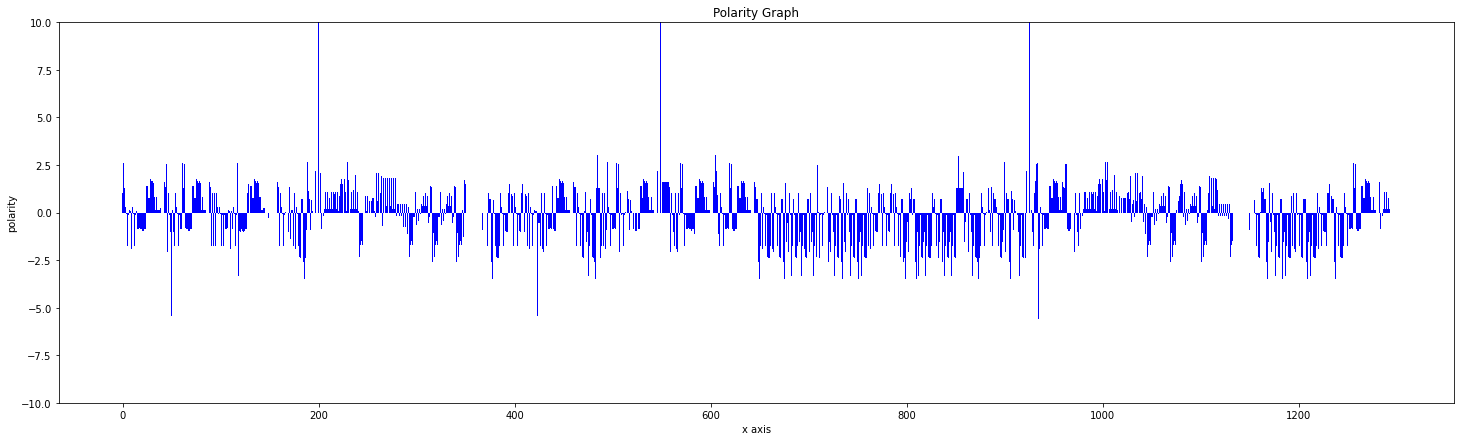

In [ ]:
import matplotlib.pyplot as plt

print(len(p_sum_list))

plt.figure(figsize=(25,7))   # 단위 inch
plt.ylim(-10, 10)            # y 축의 범위
y = p_sum_list
x = range(len(y))
plt.bar(x, y,width=1.0, color='blue')
#plt.plot(x, y, 'ob')

plt.xlabel('x axis')
plt.ylabel('polarity')
plt.title('Polarity Graph')
plt.show()

# EOF

# /var/log 파일에서 실시간으로 로그를 읽고 예측 및 감성(polarity)분석하기(원본)

In [ ]:
import os
import time   # sleep()
import datetime
from datetime import timedelta

####--------------- log 파일의 lines 수 세기 ----------------###

rpt = 0          # while loop 반복 횟수 초기화
list_ptr = [0]   # pointer(f.tell())의 위치 저장
list_line = [0]  # 파일의 line 번호

'''==============  비정상 log 파일 이름을 입력 ================      '''
while True:
    with open("test.txt", 'r') as f1:              # 처리할 log 파일 이름을 입력
        for count, line in enumerate(f1):          # enumerate()는 최소한의 메모리로 iterable 개체(string)를 count 하는데 사용됨, count에는 최종 라인의 번호가 저장됨.
            pass
    print('Total Lines', count + 1 )               # 파일의 line 수 세기

    '''---Daylight Saving Time (DST) 3월 중순~11월 첫 주에 변경 필요 ------'''
    current = datetime.datetime.now() + timedelta(hours = 9)        # 한국 시간( +9)으로 변환... timedelta는 days, hours 등을 연산하는 데 사용됨
    begin = current.replace(hour = 0, minute = 0, second = 7)       # sleep(5) 사용 시의 설정임(변경 필요)
    #print("current=", current, "begin=", begin)

    # 0시 0분 0초에 list를 초기화함.  sleep(5)를 사용하는 경우에는... 0시0분 0초 ~ 7초 사이에 이 코드가 실행되면 list를 초기화 하게됨.
    if current < begin:
        list_ptr = [0]     # f.tell()의 위치 저장
        list_line =[0]
    else:
        pass

    #if list_line[-1] != count :
    if count > list_line[-1]+2 :                      # 파일에 3 ine 이상의 log가 생성되어 있으면...
        list_line.append(count)
        print("list_line", list_line)

        ####---------------- (lines 수 - 1) 만큼 파일에서 읽기 --------------------###
        loc1 = 0                                         # file pointer 위치 초기화
        p_sum_list = []                                  # 그래프 그리기에 사용할 polarity sum의 list

        for i in range(list_line[rpt], count+1):         # list_ine[rpt] 째 줄로부터 마지막 줄까지 반복(처리)
            #print("list_line[rpt]=", list_line[rpt], "count=", count)   # ====> 첫 파일을 다 읽을 때까지 rpt==0 이다.
            print("예측 line 번호 = ", i+4)

            with open("test.txt", 'r') as f2:
                three_line = []                          # 3줄을 입력으로 사용

                f2.seek(loc1 + list_ptr[rpt], 0)         # seek()로 위치 변경
                line_1 = f2.readline()                   # 한줄 읽기

                loc1=f2.tell()                           # tell()로 한 줄을 읽은 후의 pointer 위치 측정
                #print("loc_1=", loc1)

                three_line.append(line_1)
                line_2 = f2.readline()                   # 둘째 줄 읽기
                three_line.append(line_2)
                line_3 = f2.readline()                   # 세째 줄 읽기
                three_line.append(line_3)

                line_4 = f2.readline().split()           # 리스트 뺄셈에 피감수로 시용할 라인 읽고 단어를 리스트로 저장함
                print("line_4=", line_4)

                # ''를 ' '로 변경함. map(함수, iterable) : iterable (=three_line)에 지정한 함수를 실행(\n,tab 등을 제거 용), 참고: https://nem0.tistory.com/31
                out = list(map(lambda s : ' '.join(s.split()), three_line))

                if len(out) == dim-1:
                    print("out=", out)

                    '''-------- 연속된 3개의 문장으로 다수의 Next Sentence를 예측하기 코드를 추가함-------------'''
                    seed_text = out

                    num_to_predict = 3    # 예측할  문장의 개수

                    # model.pridict에 입력할 token_list 만들기
                    seed_tok=[]
                    for i in range(dim-1):
                        sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg를 sentence 단위로 토큰화
                        seed_tok.append(sd)
                    #print("seed_tok=", seed_tok)

                    token = tokenizer.texts_to_sequences(seed_tok)
                    #print("token_list=", token)                 # 입력 문장의 index 값

                    token_list=[]
                    for a in token:
                        token_list.append(a[0])
                    token_list=[token_list]
                    #print("token_list=", token_list)            # 로그의 token_list 는 [[1, 2]] 형식의  2차원 배열로 표시되어야 함

                    print("")

                    y_prob = model.predict(token_list, verbose=0)    # model.predicted_classes 는 deprecated
                    #print(y_prob)

                    predicted_n_out = []

                    for i in range(num_to_predict):
                        predicted = y_prob[0].argmax(axis=-1)
                        #print("predicted index =", predicted)

                        prob= np.max(y_prob, axis=1)            # 2차원 array인 경우에 axis 사용함, 하나의 row에서 최대인 값
                        np.put(y_prob[0], predicted, 0)         # np.array는 요소를 delete를 하면 새 array를 return하고 원본에서는 삭제가 안된다. 단, np.put(array, index, value) 등으로 변경은 가능하다.
                        #np.delete(y_prob, predicted)

                        output_word = ""
                        for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
                            if index == predicted:
                                out_word = word
                                break
                        #print("[", i+1,"번 ]", out_word, prob)
                        predicted_n_out.append(out_word.split())
                        '''-------- 연속된 3개의 문장으로 다수의 Next Sentence를 예측하기 코드 추가. 끝.-----------'''

                    '''------------ 예측 대상 문장과 예측한 문장 내의 단어 뺄셈하기 코드 추가 ---------------------'''
                    print("predicted_n_out =", predicted_n_out)

                    words1 = line_4    # 문장을 단어로 토큰화
                    words2 = predicted_n_out
                    print("split word=", words1, words2)

                    for w in words2:
                        if w in words1:
                            words1.remove(w)   # 하나씩 제거해야 함.
                    print(words1)
                    print("\n")

                    polar = [[0]]                     # 뺄셈으로 polar=[]이 되면 concatenate 오류가 발생하므로 [0]을 추가했음.

                    for w in words1:
                        #if w in get_word.values():   # dict에서 value를 검색할 때
                        if w in val_dict:             # key를 검색할 때만 in dict 를 사용 가능
                            #print(w)
                            c = val_dict.get(w)
                            polar.append(c)
                    print("polarity =", polar)

                    p_list = np.concatenate(polar).tolist()  # 2차원 리스트를 1차원으로 변경 --> polar =[]이 되면 concatenate() 오류 발생
                    p_sum = round(sum(p_list), 4)                       # List 값의 합계 계산하고, 소수점 4자리까지 지정하기
                    print("sum=", p_sum)

                    p_sum_list.append(p_sum)
                    print("p_sum_list=",p_sum_list)

                    '''--------------------------------------------------------------------------------------------'''
                elif len(out[1])==0:
                    break

                loc2 = f2.tell()

            #print("loc_2=", loc2)
            print("\n")
            i=i+1
    else:
        pass

    rpt = rpt + 1    # while loop 반복할 때마다 1씩  증가

    if list_ptr[-1] != loc2:
        list_ptr.append(loc2)
    else: pass
    print("list_ptr=", list_ptr)
    #print("p_sum_list=",p_sum_list)

    time.sleep(5)    ##########  5초 대기 ---> 시간 조정할 것

    # rpt = 20만회 반복 시험 이상 무

# /var/log 파일에서 2개 로그를 읽고 예측 및 3째 문장에 대한 감성 분석하기(원본)
 dim=3으로 학습한 경우에 사용 가능함

In [ ]:
import os
import time   # sleep()
import datetime
from datetime import timedelta

####--------------- log 파일의 lines 수 세기 ----------------###

rpt = 0          # while loop 반복 횟수 초기화
list_ptr = [0]   # pointer(f.tell())의 위치 저장
list_line = [0]  # 파일의 line 번호

'''==============  비정상 log 파일 이름을 입력 ================      '''
while True:
    with open("test.txt", 'r') as f1:              # 처리할 log 파일 이름을 입력
        for count, line in enumerate(f1):          # enumerate()는 최소한의 메모리로 iterable 개체(string)를 count 하는데 사용됨, count에는 최종 라인의 번호가 저장됨.
            pass
    print('Total Lines', count + 1 )               # 파일의 line 수 세기

    '''---Daylight Saving Time (DST) 3월 중순~11월 첫 주에 변경 필요 ------'''
    current = datetime.datetime.now() + timedelta(hours = 9)        # 한국 시간( +9)으로 변환... timedelta는 days, hours 등을 연산하는 데 사용됨
    begin = current.replace(hour = 0, minute = 0, second = 7)       # sleep(5) 사용 시의 설정임(변경 필요)
    #print("current=", current, "begin=", begin)

    # 0시 0분 0초에 list를 초기화함.  sleep(5)를 사용하는 경우에는... 0시0분 0초 ~ 7초 사이에 이 코드가 실행되면 list를 초기화 하게됨.
    if current < begin:
        list_ptr = [0]     # f.tell()의 위치 저장
        list_line =[0]
    else:
        pass

    #if list_line[-1] != count :
    if count > list_line[-1]+2 :                      # 파일에 3 ine 이상의 log가 생성되어 있으면...
        list_line.append(count)
        print("list_line", list_line)

        ####---------------- lines 수 만큼 파일에서 읽기 --------------------###
        loc1 = 0                                      # file pointer 위치 초기화
        p_sum_list = []                               # 그래프 그리기에 사용할 polarity sum의 list

        for i in range(list_line[rpt], count):        # list_ine[rpt] 째 줄로부터 total_line -1 줄까지만 반복(처리)
            #print("list_line[rpt]=", list_line[rpt], "count=", count)   # =====> 파일을 다 읽을 때까지 rpt==0 이다.
            print("예측 line 번호 = ", i+3)

            with open("test.txt", 'r') as f2:
                two_line = []

                f2.seek(loc1 + list_ptr[rpt], 0)         # seek()로 위치 변경
                line_1 = f2.readline()                   # 한줄 읽기

                loc1=f2.tell()                           # tell()로 한 줄을 읽은 후의 pointer 위치 측정
                #print("loc_1=", loc1)

                two_line.append(line_1)
                line_2 = f2.readline()                   # 둘째 줄 읽기
                two_line.append(line_2)

                line_3 = f2.readline().split()           # 뺄셈에 피감수로 시용할 라인 읽고 단어를 리스트로 저장함
                print("line_3=", line_3)

                # ''를 ' '로 변경함. map(함수, iterable) : iterable(=two_line)에 지정한 함수(\n,tab 등을 제거)를 실행, 참고: https://nem0.tistory.com/31
                out = list(map(lambda s : ' '.join(s.split()), two_line))

                if len(out) == 2:
                    print("out=", out)

                    '''-------- 연속된 2개의 문장으로 다수의 Next Sentence를 예측하기 코드를 추가함-------------'''
                    seed_text = out

                    num_to_predict = 3                              # 예측할  다음 문장의 개수

                    # model.pridict에 입력할 token_list 만들기
                    seed_tok=[]
                    for i in range(2):
                        sd =  nltk.sent_tokenize(seed_text[i])       #  한 줄의 log msg를 sentence 단위로 토큰화
                        seed_tok.append(sd)
                    #print("seed_tok=", seed_tok)

                    token = tokenizer.texts_to_sequences(seed_tok)
                    #print("token_list=", token)                     # 입력 문장의 index 값

                    token_list=[]
                    for a in token:
                        token_list.append(a[0])
                    token_list=[token_list]
                    #print("token_list=", token_list)                # 로그의 token_list 는 [[1, 2]] 형식의  2차원 배열로 표시되어야 함

                    print("")

                    y_prob = model.predict(token_list, verbose=0)    # model.predicted_classes 는 deprecated
                    #print(y_prob)

                    predicted_n_out = []

                    for i in range(num_to_predict):
                        predicted = y_prob[0].argmax(axis=-1)
                        #print("predicted index =", predicted)

                        prob= np.max(y_prob, axis=1)            # 2차원 array인 경우에 axis 사용함, 하나의 row에서 최대인 값
                        np.put(y_prob[0], predicted, 0)         # np.array는 요소를 delete를 하면 새 array를 return하고 원본에서는 삭제가 안된다. 단, np.put(array, index, value) 등으로 변경은 가능하다.
                        #np.delete(y_prob, predicted)

                        output_word = ""
                        for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
                            if index == predicted:
                                out_word = word
                                break
                        #print("[", i+1,"번 ]", out_word, prob)
                        predicted_n_out.append(out_word.split())

                        '''-------- 연속된 2개의 문장으로 다수의 Next Sentence를 예측하기 코드 추가. 끝.-----------'''


                    '''------------ 예측 대상 문장과 예측한 문장 내의 단어 뺄셈하기 코드 추가 ---------------------'''
                    print("predicted_n_out =", predicted_n_out)

                    words1 = line_3    # 문장을 단어로 토큰화
                    words2 = predicted_n_out
                    print("split word=", words1, words2)

                    for w in words2:
                        if w in words1:
                            words1.remove(w)   # 하나씩 제거해야 함.
                    print(words1)
                    print("\n")

                    polar = [[0]]                     # 뺄셈으로 polar=[]이 되면 concatenate 오류가 발생하므로 [0]을 추가했음.

                    for w in words1:
                        #if w in get_word.values():   # dict에서 value를 검색할 때
                        if w in val_dict:             # key를 검색할 때만 in dict 를 사용 가능
                            #print(w)
                            c = val_dict.get(w)
                            polar.append(c)
                    print("polarity =", polar)

                    p_list = np.concatenate(polar).tolist()  # 2차원 리스트를 1차원으로 변경 --> polar =[]이 되면 concatenate() 오류 발생
                    p_sum = round(sum(p_list), 4)                       # List 값의 합계 계산하고, 소수점 4자리까지 지정하기
                    print("sum=", p_sum)

                    p_sum_list.append(p_sum)
                    print("p_sum_list=",len(p_sum_list), p_sum_list)

                    '''--------------------------------------------------------------------------------------------'''
                elif len(out[1])==0:
                    break

                loc2 = f2.tell()

            #print("loc_2=", loc2)
            print("\n")
            i=i+1
    else:
        pass

    rpt = rpt + 1    # while loop 반복할 때마다 1씩  증가

    if list_ptr[-1] != loc2:
        list_ptr.append(loc2)
    else: pass
    print("list_ptr=", list_ptr)
    #print("p_sum_list=",p_sum_list)

    time.sleep(5)    ##########  5초 대기 ---> 시간 조정할 것

    # rpt = 20만회 반복 시험 이상 무

# Polarity 그래프 그리기

1758


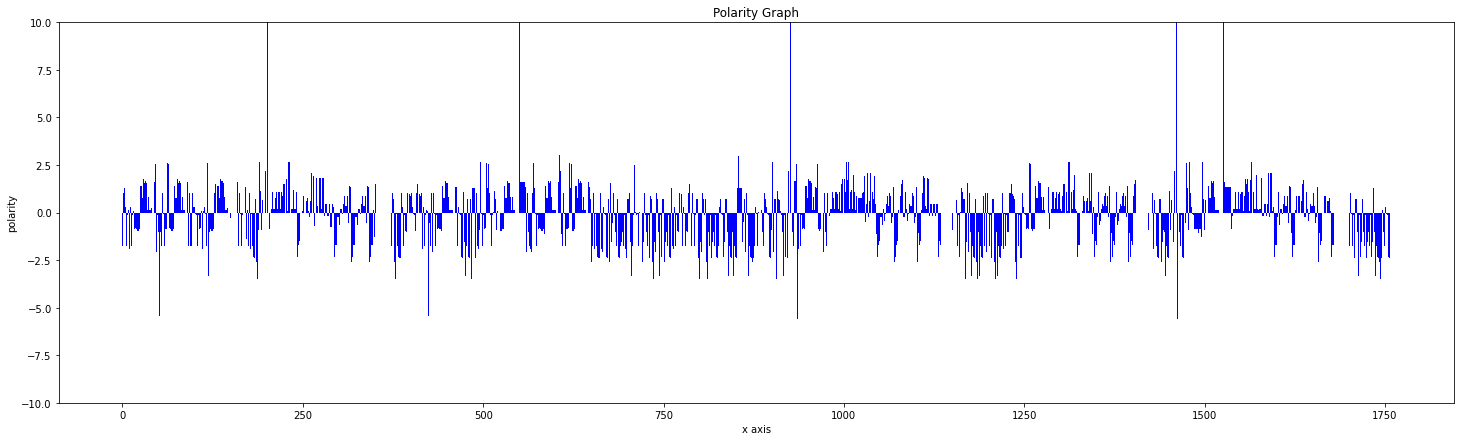

In [ ]:
import matplotlib.pyplot as plt

print(len(p_sum_list))

plt.figure(figsize=(25,7))   # 단위 inch
plt.ylim(-10, 10)            # y 축의 범위
y = p_sum_list
x = range(len(y))
plt.bar(x, y,width=1.0, color='blue')
#plt.plot(x, y, 'ob')

plt.xlabel('x axis')
plt.ylabel('polarity')
plt.title('Polarity Graph')
plt.show()

# EOF

연속된 2개의 문장으로 다수의 Next Sentence를 예측하기

In [ ]:
# dim=4로 학습한 모델을 사용하여, 3개 문장을 입력하는 대신에... 2개 문장만 입력하여 다음 문장을 3개 예측하면 그 첫문장은 동일하지만 나머지 2문장은 다른 것이 출력됨.

seed_text = 'systemd-logind session logged waiting processes exit', 'systemd started session user ubuntu'

num_to_predict = 3    # 예측할  다음 문장의 개수
''' --------------------  실제 log msg를 파일에서 읽어 처리할 때  ------------------------'''
# model.pridict에 입력할 token_list 만들기
seed_tok=[]
for i in range(2):
    sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg를 sentence 단위로 토큰화
    seed_tok.append(sd)
print("seed_tok=", seed_tok)

token = tokenizer.texts_to_sequences(seed_tok)
print("token_list=", token)                 # 입력 문장의 index 값

token_list=[]
for a in token:
    token_list.append(a[0])
token_list=[token_list]
print("token_list=", token_list)            # token_list = [[1, 2]] 와 같은 2차원 배열로 표시되어야 함
'''-------------------------------------------------------------------------------------------'''
print("")

y_prob = model.predict(token_list, verbose=0)    # model.predicted_classes 는 deprecated
#print(y_prob)

for i in range(num_to_predict):
    predicted = y_prob[0].argmax(axis=-1)
    print("predicted index =", predicted)

    prob= np.max(y_prob, axis=1)         # 2차원 array인 경우에 axis 사용함, 하나의 row에서 최대인 값
    np.put(y_prob[0], predicted, 0)         # np.array는 요소를 delete를 하면 새 array를 return하고 원본에서는 삭제가 안된다. 단, np.put(array, index, value) 등으로 변경은 가능하다.
    #np.delete(y_prob, predicted)

    output_word = ""
    for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
        if index == predicted:
            output_word = word
            break
    print("[", i+1,"번 ]", output_word, prob)


seed_tok= [['systemd-logind session logged waiting processes exit'], ['systemd started session user ubuntu']]
token_list= [[26], [20]]
token_list= [[26, 20]]

predicted index = 28
[ 1 번 ] systemd sessionscope succeeded [0.3203633]
predicted index = 23
[ 2 번 ] sshd pamunixsshdsession session closed user ubuntu [0.24389638]
predicted index = 188
[ 3 번 ] sshd received disconnect port disconnected user [0.06434044]


# /var/log 파일에서 실시간 로그 읽고 예측 및 감성(polarity) 분석하기(원본)

In [ ]:
import os
import time   # sleep()
import datetime
from datetime import timedelta

####--------------- log 파일의 lines 수 세기 ----------------###

rpt = 0          # while loop 반복 횟수 초기화
list_ptr = [0]   # pointer(f.tell())의 위치 저장
list_line = [0]  # 파일의 line 번호

'''==============  비정상 log 파일 이름을 입력 ================      '''
while True:
    with open("test.txt", 'r') as f1:                     # 비정상 log 파일 이름을 입력
        for count, line in enumerate(f1):                 # enumerate()는 최소한의 메모리로 iterable 개체(string)를 count 하는데 사용됨
            pass
    #print('Total Lines', count + 1 )                      # 파일의 line 수 세기

    '''---Daylight Saving Time (DST) 3월 중순~11월 첫 주에 변경 필요 ------'''
    current = datetime.datetime.now() + timedelta(hours = 9)        # 한국 시간( +9)으로 변환... tiemdelta는 days, hours 등을 연산하는 데 사용됨
    begin = current.replace(hour = 0, minute = 0, second = 7)       # sleep(5) 사용 시의 설정임(변경 필요)
    #print("current=", current, "begin=", begin)

    # 0시 0분 0초에 list를 초기화함.  sleep(5)를 사용하는 경우에는... 0시0분 0초 ~ 7초 사이에 이 코드가 실행되면 list를 초기화 하게됨.
    if current < begin:
        list_ptr = [0]
        list_line =[0]
    else:
        pass

    #if list_line[-1] != count :
    if count > list_line[-1]+1 : # 파일에 2 lines 이상의 log가 생성되어 있으면...
        list_line.append(count)
        print("list_line", list_line)

        ####---------------- (lines 수 - 1) 만큼 파일에서 읽기 --------------------###
        loc1 = 0                                      # file pointer 위치 초기화
        p_sum_list = []                               # 그래프 그리기에 사용할 list

        for i in range(list_line[rpt], count):        # list_ine[rpt] 째 줄로부터 total_line -1 줄까지만 반복(처리)
            print("예측 line 번호 = ", i+3)

            with open("test.txt", 'r') as f2:
                two_line = []                         ####################### three_line으로 수정할 것

                f2.seek(loc1 + list_ptr[rpt], 0)         # seek(offset, 기준점)로 위치 변경.
                line_1 = f2.readline()                   # 한줄 읽기

                loc1=f2.tell()                           # tell()로 한 줄을 읽은 후의 pointer 위치 측정 ---> 3줄씩 읽을 때 다음 시작 위치임.
                #print("loc_1=", loc1)

                two_line.append(line_1)
                line_2 = f2.readline()                   # 둘째 줄 읽기
                two_line.append(line_2)

                line_3 = f2.readline().split()                   # 뺄셈에 피감수로 시용할 라인 읽기
                print("line_3=", line_3)

                # ''를 ' '로 변경함. map(함수, iterable) : iterable(=two_line)에 지정한 함수(\n,tab 등을 제거)를 실행, 참고: https://nem0.tistory.com/31
                out = list(map(lambda s : ' '.join(s.split()), two_line))

                if len(out) == 2:
                    #print(out)
                    '''-------- 연속된 2개의 문장으로 다수의 Next Sentence를 예측하기 코드를 추가함-------------'''
                    seed_text = out

                    num_to_predict = 5    # 예측할  다음 문장의 개수

                    # model.pridict에 입력할 token_list 만들기
                    seed_tok=[]
                    for i in range(2):
                        sd =  nltk.sent_tokenize(seed_text[i])   #  한 줄의 log msg를 sentence 단위로 토큰화
                        seed_tok.append(sd)
                    #print("seed_tok=", seed_tok)

                    token = tokenizer.texts_to_sequences(seed_tok)
                    #print("token_list=", token)                 # 입력 문장의 index 값

                    token_list=[]
                    for a in token:
                        token_list.append(a[0])
                    token_list=[token_list]
                    #print("token_list=", token_list)            # token_list = [[1, 2]] 와 같은 2차원 배열로 표시되어야 함

                    print("")

                    y_prob = model.predict(token_list, verbose=0)    # model.predicted_classes 는 deprecated
                    #print(y_prob)

                    predicted_n_out = []

                    for i in range(num_to_predict):
                        predicted = y_prob[0].argmax(axis=-1)
                        #print("predicted index =", predicted)

                        prob= np.max(y_prob, axis=1)            # 2차원 array인 경우에 axis 사용함, 하나의 row에서 최대인 값
                        np.put(y_prob[0], predicted, 0)         # np.array는 요소를 delete를 하면 새 array를 return하고 원본에서는 삭제가 안된다. 단, np.put(array, index, value) 등으로 변경은 가능하다.
                        #np.delete(y_prob, predicted)

                        output_word = ""
                        for word, index in tokenizer.word_index.items():   # 실제 단어로 변환하여 출력에 append 함.
                            if index == predicted:
                                out_word = word
                                break
                        #print("[", i+1,"번 ]", out_word, prob)
                        predicted_n_out.append(out_word.split())
                        '''-------- 연속된 2개의 문장으로 다수의 Next Sentence를 예측하기 코드 추가. 끝.-----------'''

                    '''------------ 예측 대상 문장과 예측한 문장 내의 단어 뺄셈하기 코드 추가 ---------------------'''
                    print("predicted_n_out =", predicted_n_out)

                    words1 = line_3    # 문장을 단어로 토큰화
                    words2 = predicted_n_out
                    print("split word=", words1, words2)

                    for w in words2:
                        if w in words1:
                            words1.remove(w)   # 하나씩 제거해야 함.
                    print(words1)
                    print("\n")

                    #val_dict = df.to_dict()   # dict 변환 기본 명령
                    # df의 특정 column을 key로 사용하여 value를 list로 출력하고자 할때, 여기서는 column = 0을 key로 사용함
                    #val_dict= df.set_index(0).T.to_dict('list')   #  df를  {'fags': [-0.879],...} 형태로 변환, ==> 32 초 소요
                    #print("val_dict=", val_dict)
                    #print("\n")

                    polar = [[0]]                     # 뺄셈으로 polar=[]이 되면 concatenate 오류가 발생하므로 [0]을 추가했음.

                    for w in words1:
                        #if w in get_word.values():   # dict에서 value를 검색할 때
                        if w in val_dict:             # key를 검색할 때만 in dict 를 사용 가능
                            print(w)
                            c = val_dict.get(w)
                            polar.append(c)
                    print("polarity =", polar)

                    p_list = np.concatenate(polar).tolist()  # 2차원 리스트를 1차원으로 변경 --> polar =[]이 되면 concatenate() 오류 발생
                    p_sum = round(sum(p_list), 4)                       # List 값의 합계 계산하고, 소수점 4자리까지 지정하기
                    print("sum=", p_sum)

                    p_sum_list.append(p_sum)
                    print("p_sum_list=",p_sum_list)

                    '''--------------------------------------------------------------------------------------------'''
                elif len(out[1])==0:
                    break

                loc2 = f2.tell()

            print("loc_2=", loc2)
            print("\n")
            i=i+1
    else:
        pass

    rpt = rpt + 1    # while loop 반복할 때마다 1씩  증가

    if list_ptr[-1] != loc2:
        list_ptr.append(loc2)
    else: pass
    print("list_ptr=", list_ptr)
    #print("p_sum_list=",p_sum_list)

    time.sleep(5)    ##########  5초 대기 ---> 시간 조정할 것

    # rpt = 20만회 반복 시험 이상 무

1016


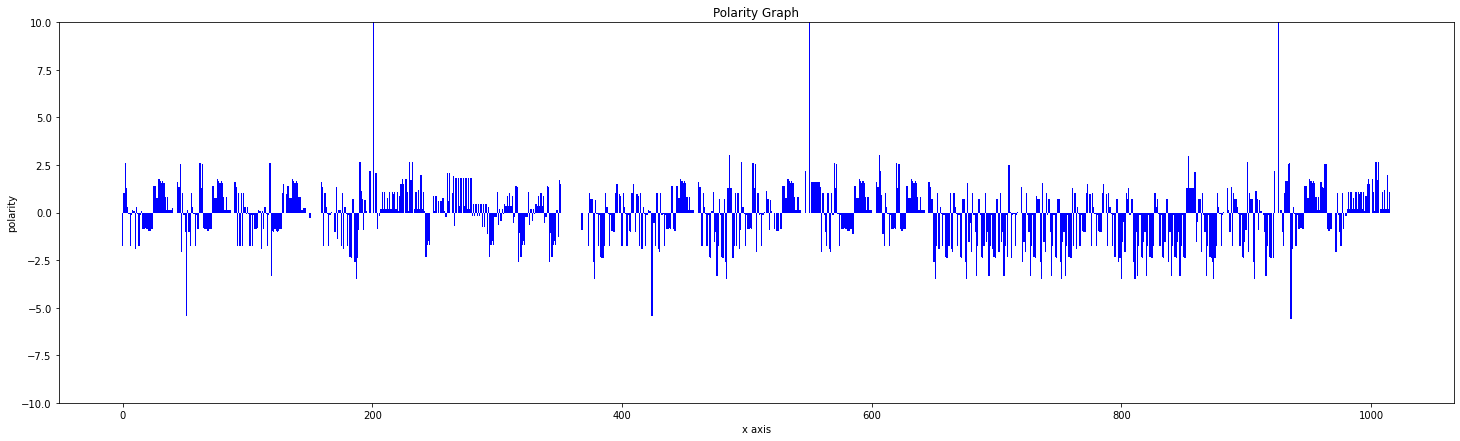

In [ ]:
import matplotlib.pyplot as plt

print(len(p_sum_list))

plt.figure(figsize=(25,7))   # 단위 inch
plt.ylim(-10, 10)            # y 축의 범위
y = p_sum_list
x = range(len(y))
plt.bar(x, y,width=1.0, color='blue')
#plt.plot(x, y, 'ob')

plt.xlabel('x axis')
plt.ylabel('polarity')
plt.title('Polarity Graph')
plt.show()

# 리스트 뺄셈 및 Senticnet으로 감성 분석하기

In [ ]:
str1= 'systemd starting rotate log files fail systemd starting daily mandb regeneration failed systemd log rotate service succeeded failure'
str2= 'systemd starting daily mandb regeneration'

words1 = str1.split()    # 문장을 단어로 토큰화
words2 = str2.split()

print(words1)

for i in words2:
    if i in words1:
        words1.remove(i)   # 하나씩 제거해야 함.
print(words1)
print("\n")

#val_dict = df.to_dict()   # dict 변환 기본 명령
# df의 특정 column을 key로 사용하여 value를 list로 출력하고자 할때, 여기서는 column = 0을 key로 사용함
val_dict= df.set_index(0).T.to_dict('list')   #  df를  {'fags': [-0.879],...} 형태로 변환, ==> 32 초 소요
#print("val_dict=", val_dict)
#print("\n")

polar = [[0]]                     # 뺄셈으로 polar=[] 이 되면 아래에서 concatenate 오류가 발생함
for i in words1:
    #if i in get_word.values():   # dict에서 value를 검색할 때
    if i in val_dict:             # key를 검색할 때만 in dict 를 사용 가능
        print(i)
        c = val_dict.get(i)
        polar.append(c)
print("polarity =", polar)

p_list = np.concatenate(polar).tolist()  # 2차원 리스트를 1차원으로 변경,--> polar =[] 이되면 error
print(sum(p_list))                       # List 값의 합계 계산하기


['systemd', 'starting', 'rotate', 'log', 'files', 'fail', 'systemd', 'starting', 'daily', 'mandb', 'regeneration', 'failed', 'systemd', 'log', 'rotate', 'service', 'succeeded', 'failure']
['rotate', 'log', 'files', 'fail', 'systemd', 'starting', 'failed', 'systemd', 'log', 'rotate', 'service', 'succeeded', 'failure']


rotate
fail
starting
failed
rotate
succeeded
failure
polarity = [[0.903], [-0.94], [-0.877], [-0.94], [0.903], [0.996], [-0.771]]
-0.7259999999999999


(참고) 1. Google Drive에 연결하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


2. 아래 명령으로 Google Drive에 model을 저장하고, PC로 다운로드했음

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/lstm_sent_predict_train.h5') # Colab 좌측 창에 임시 저장된 h5 파일을 다운로드 하여 저장한다.

(참고) Source Code 저장하기

In [ ]:
# 인용--> https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221564411127&categoryNo=49&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView

from os import path
from google.colab import drive

notebooks_dir_name = 'Colab Notebooks'
drive.mount('/content/drive')
notebooks_base_dir = path.join('./drive/My Drive/', notebooks_dir_name)
if not path.exists(notebooks_base_dir):
    print('Check your google drive directory"')

with open(path.join(notebooks_base_dir, "파일 이름"),"w") as f:
          f.write("Colab Keras code saved")

In [ ]:
from keras.models import load_model

model.save('lstm_sent_predict')  # 모델을 저장

del model       # 테스트를 위해 Colab 메모리 내의 모델을 삭제
loaded_model = model.load('lstm_sent_predict') # 모델을 새로 불러옴

print("\n Test Accuracy: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))  # 불러온 모델로 테스트 실행